# Vertiefte Analyse der Bauphasen 4, 5 und 6

Im anderen Script '`Wylerfeld.ipynb`' ist ersichtlich, dass die Abminderungsfaktoren für die Bauphasen 4, 5 und 6 mit $\sim 0.36$ deutlich tiefer sind als erwartet. Um das etwas mehr ins Detail zu untersuchen haben wir eine zusätzliche Simulation mit Plaxis durchgeführt, wobei für die Steifigkeit der Spundwand einen Abminderungsfakton von $\beta_D = 0.3$ angenommen wurde.

In diesem Skript werten wir nur die Bauphasen 4, 5 und 6 (Plaxis-2D, mit $\beta_D = 0.3$) und die Inklinometermessung vom 15.05.2020 aus.

**Input:**
*   eine csv-Datei '`df_inclino_I-52S_I-52N.csv`' mit den Rohdaten der beiden Inklinometer. Diese Datei wurde zum Teil von Hand, zum Teil mit Hilfe eines Python-Codes erstellt (nicht verfügbar auf Google Colab). Am 21.08.2020 wurde nur der Inklino I-52S gemessen. Diese Messung wird manuell aus der Datenbank entfernt, weil sie zu Schwierigkeiten in der Auswertung führt.
*   eine csv-Datei '`Plaxis_03_Moment_Nord.csv`' mit den Momenten in der Spundwand Nord, berechnet mit Plaxis-2D.
*   eine csv-Datei '`Plaxis_03_Moment_Süd.csv`' mit den Momenten in der Spundwand Süd, berechnet mit Plaxis-2D.
*   eine csv-Datei '`Plaxis_03_Verformung_Nord.csv`' mit der Verformung der Spundwand Nord, berechnet mit Plaxis-2D.
*   eine csv-Datei '`Plaxis_03_Verformung_Süd.csv`' mit der Verformung der Spundwand Süd, berechnet mit Plaxis-2D.

In [1]:
#test_flag_colab
from google.colab import drive
drive.mount('/content/drive')

# working directory: drive/MyDrive/spundsteif
%cd '/content/drive/MyDrive/spundsteif'

%load_ext autoreload
%autoreload 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/spundsteif


# Libraries importieren

In [2]:
import pandas as pd
import numpy as np
import io
import csv
import re
from datetime import datetime, date

from google.colab import files

from copy import copy

from datetime import timedelta
from datetime import datetime

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Daten importieren

## Daten Inklinometer

In [3]:
df = pd.read_csv('./data/df_inclino_I-52S_I-52N.csv', delimiter=';', header=[0])

# convert the dates from str to datetime
for index, row in df.iterrows():
  df.at[index, 'date'] = pd.to_datetime(df['date'][index], dayfirst=True)

# set the date as the index
df.set_index('date', inplace=True)

df

,tube,depth,A+,A-,B+,B-
date,,,,,,
2020-03-06,I-52N,0.5,419,-212,-1592,1339
2020-03-06,I-52N,1.0,402,-183,-1657,1389
2020-03-06,I-52N,1.5,338,-124,-1755,1525
2020-03-06,I-52N,2.0,316,-125,-1724,1391
2020-03-06,I-52N,2.5,440,-235,-1347,1052
...,...,...,...,...,...,...
2020-09-01,I-52S,14.0,-292,498,247,-427
2020-09-01,I-52S,14.5,-678,879,204,-392
2020-09-01,I-52S,15.0,-905,1113,187,-393


## Daten Plaxis-2D

Notation:

*   df: Dataframe
*   u: Verformung in [m]
*   M: Moment in [kNm/m]
*   S: Spundwand Süd
*   N: Spundwand Nord

In [4]:
# Plaxis displacement data, sheet pile wall North
df_plaxis_uN_03 = pd.read_csv('./data/Plaxis_03_Verformung_Nord.csv', delimiter=';')
df_plaxis_uN_03.dropna(how='all')
#df_plaxis_uN_03

,X_coordinate_[m]_03,Y_coordinate_[m]_03,untere_Spriesse_Phase3_[m]_03,Aushub_Phase4_[m]_03,Materialersatz_Phase5_[m]_03,Bodenplatte_Phase6_[m]_03,Rückbau_Spriesse_Phase7_[m]_03,Spundwand_realisieren_Phase1_[m]_03,Aushub_Phase2_[m]_03
0,12.0,1.00,0.01000,0.00441,0.00437,0.00422,0.00841,-0.00156,0.01060
1,12.0,0.75,0.00441,-0.00134,-0.00139,-0.00154,0.00126,-0.00179,0.00487
2,12.0,0.50,-0.00118,-0.00709,-0.00714,-0.00730,-0.00589,-0.00202,-0.00084
3,12.0,0.25,-0.00677,-0.01280,-0.01290,-0.01310,-0.01300,-0.00225,-0.00655
4,12.0,0.00,-0.01240,-0.01860,-0.01860,-0.01880,-0.02020,-0.00249,-0.01230
...,...,...,...,...,...,...,...,...,...
80,12.0,-14.89,-0.00317,-0.01270,-0.01270,-0.01270,-0.01300,-0.00235,-0.00322
81,12.0,-15.17,-0.00299,-0.00973,-0.00973,-0.00972,-0.00999,-0.00228,-0.00303
82,12.0,-15.45,-0.00283,-0.00685,-0.00686,-0.00686,-0.00709,-0.00222,-0.00286
83,12.0,-15.72,-0.00267,-0.00406,-0.00407,-0.00407,-0.00427,-0.00217,-0.00271


In [5]:
# Plaxis displacement data, sheet pile wall South
df_plaxis_uS_03 = pd.read_csv('./data/Plaxis_03_Verformung_Süd.csv', delimiter=';')
df_plaxis_uS_03.dropna(how='all')
#df_plaxis_uS_03

,X_coordinate_[m]_03,Y_coordinate_[m]_03,untere_Spriesse_Phase3_[m]_03,Aushub_Phase4_[m]_03,Materialersatz_Phase5_[m]_03,Bodenplatte_Phase6_[m]_03,Rückbau_Spriesse_Phase7_[m]_03,Spundwand_realisieren_Phase1_[m]_03,Aushub_Phase2_[m]_03
0,0.0,1.00,-0.03410,-0.040000,-0.040100,-0.040300,-0.046600,-0.00531,-0.03440
1,0.0,0.75,-0.02860,-0.034500,-0.034600,-0.034700,-0.039700,-0.00509,-0.02870
2,0.0,0.50,-0.02310,-0.029000,-0.029100,-0.029200,-0.032800,-0.00488,-0.02310
3,0.0,0.25,-0.01760,-0.023500,-0.023600,-0.023700,-0.026000,-0.00466,-0.01750
4,0.0,0.00,-0.01210,-0.018000,-0.018100,-0.018100,-0.019100,-0.00445,-0.01190
...,...,...,...,...,...,...,...,...,...
80,0.0,-14.89,-0.00121,0.002140,0.002130,0.002110,0.002180,-0.00159,-0.00116
81,0.0,-15.17,-0.00127,0.001080,0.001080,0.001060,0.001120,-0.00156,-0.00122
82,0.0,-15.45,-0.00131,0.000099,0.000102,0.000081,0.000130,-0.00152,-0.00126
83,0.0,-15.72,-0.00135,-0.000832,-0.000825,-0.000848,-0.000811,-0.00149,-0.00131


In [6]:
# Plaxis moment data, sheet pile wall North
df_plaxis_MN_03 = pd.read_csv('./data/Plaxis_03_Moment_Nord.csv', delimiter=';')
df_plaxis_MN_03.dropna(how='all')
#df_plaxis_MN_03

,X_coordinate_[m]_03,Y_coordinate_[m]_03,untere_Spriesse_Phase3_[kNm/m]_03,Aushub_Phase4_[kNm/m]_03,Materialersatz_Phase5_[kNm/m]_03,Bodenplatte_Phase6_[kNm/m]_03,Rückbau_Spriesse_Phase7_[kNm/m]_03,Spundwand_realisieren_Phase1_[kNm/m]_03,Aushub_Phase2_[kNm/m]_03
0,12.0,1.00,2.820000e-15,-8.600000e-14,-1.180000e-14,8.780000e-14,3.420000e-14,4.570000e-15,-3.770000e-15
1,12.0,0.75,6.980000e-15,-5.070000e-14,3.980000e-15,2.020000e-13,-2.100000e-14,3.080000e-15,4.690000e-14
2,12.0,0.50,1.030000e-15,-1.230000e-13,-2.180000e-14,-1.960000e-14,1.430000e-14,7.150000e-15,1.190000e-14
3,12.0,0.25,-1.670000e-14,-2.370000e-13,-3.750000e-14,-1.480000e-13,6.360000e-14,7.040000e-15,-7.640000e-15
4,12.0,0.00,-3.110000e-14,1.030000e-13,-8.880000e-16,1.170000e-13,2.660000e-13,6.230000e-14,-6.190000e-14
...,...,...,...,...,...,...,...,...,...
80,12.0,-14.89,1.620000e+01,7.920000e+01,7.860000e+01,7.710000e+01,7.710000e+01,2.990000e+00,1.650000e+01
81,12.0,-15.17,1.260000e+01,7.340000e+01,7.260000e+01,7.120000e+01,7.170000e+01,2.780000e+00,1.290000e+01
82,12.0,-15.45,7.020000e+00,5.070000e+01,5.020000e+01,4.930000e+01,4.970000e+01,1.820000e+00,7.170000e+00
83,12.0,-15.72,1.910000e+00,2.200000e+01,2.180000e+01,2.150000e+01,2.170000e+01,6.900000e-01,1.950000e+00


In [7]:
# Plaxis moment data, sheet pile wall South
df_plaxis_MS_03 = pd.read_csv('./data/Plaxis_03_Moment_Süd.csv', delimiter=';')
df_plaxis_MS_03.dropna(how='all')
#df_plaxis_MS_03

,X_coordinate_[m]_03,Y_coordinate_[m]_03,untere_Spriesse_Phase3_[kNm/m]_03,Aushub_Phase4_[kNm/m]_03,Materialersatz_Phase5_[kNm/m]_03,Bodenplatte_Phase6_[kNm/m]_03,Rückbau_Spriesse_Phase7_[kNm/m]_03,Spundwand_realisieren_Phase1_[kNm/m]_03,Aushub_Phase2_[kNm/m]_03
0,0.0,1.00,4.640000e-15,-9.870000e-15,9.930000e-15,4.900000e-14,-5.150000e-15,-3.460000e-14,-1.270000e-13
1,0.0,0.75,-3.610000e-15,7.970000e-14,1.610000e-14,1.640000e-13,1.280000e-14,-6.180000e-15,-5.440000e-15
2,0.0,0.50,-9.420000e-15,4.290000e-14,1.850000e-14,5.510000e-14,1.240000e-14,-2.530000e-15,6.760000e-15
3,0.0,0.25,-1.830000e-14,-4.300000e-14,3.250000e-15,-8.530000e-14,3.690000e-14,-3.460000e-15,1.970000e-14
4,0.0,0.00,-1.890000e-14,7.980000e-14,-3.440000e-14,4.490000e-14,4.180000e-14,-2.410000e-14,1.430000e-14
...,...,...,...,...,...,...,...,...,...
80,0.0,-14.89,-7.060000e+00,-5.890000e+01,-5.830000e+01,-5.660000e+01,-5.520000e+01,1.800000e+00,-7.460000e+00
81,0.0,-15.17,-6.390000e+00,-5.010000e+01,-4.940000e+01,-4.800000e+01,-4.720000e+01,1.640000e+00,-6.690000e+00
82,0.0,-15.45,-4.050000e+00,-3.100000e+01,-3.060000e+01,-2.980000e+01,-2.950000e+01,1.070000e+00,-4.220000e+00
83,0.0,-15.72,-1.440000e+00,-1.110000e+01,-1.100000e+01,-1.080000e+01,-1.070000e+01,4.130000e-01,-1.500000e+00


# Auswertung der Inklinometerdaten

In [8]:
# compute average values

df[('A_average')] = (df['A+'] - df['A-']) / 2
df[('B_average')] = (df['B+'] - df['B-']) / 2

df = df.sort_index(axis=1)

In [9]:
# compute the rotation angle

# the inclinometer constant is equal to 100'000.
constant_inclino = 100000

df[('A_rotation')] = df[('A_average')] / constant_inclino
df[('B_rotation')] = df[('B_average')] / constant_inclino

df = df.sort_index(axis=1)

In [10]:
def deformation(list_incl):
  """
  Computes the displacement from top (depth=0) to bottom (depth=16.0)
  """
  w = 0
  list_w = []

  for theta in list_incl[::-1]:
    w += .5 * np.sin(theta)
    list_w.append(w)

  list_w.reverse()

  return list_w

In [11]:
 # compute the deformations

dates = set(df.index)
#dates
tubes = set(df['tube'])
#tubes


for date in dates:
  for tube in tubes:

    # select one single measurement:
    df_one_measurement = df.loc[(df.index == date) & (df['tube'] == tube)]
    # make sure it is sorted correctly with respect to depth
    df_one_measurement.sort_values(by=['depth'], ascending=True, inplace=True)

    # now compute the lateral and transversal displacement, respectively
    df.loc[(df.index == date) & (df['tube'] == tube), ('A_defo')] = deformation(df_one_measurement['A_rotation']) # defo stands for deformation
    df.loc[(df.index == date) & (df['tube'] == tube), ('B_defo')] = deformation(df_one_measurement['B_rotation'])

df.head()

<ipython-input-11-64b287b6114c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_one_measurement.sort_values(by=['depth'], ascending=True, inplace=True)
<ipython-input-11-64b287b6114c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_one_measurement.sort_values(by=['depth'], ascending=True, inplace=True)


,A+,A-,A_average,A_rotation,B+,B-,B_average,B_rotation,depth,tube,A_defo,B_defo
date,,,,,,,,,,,,
2020-03-06,419,-212,315.5,0.003155,-1592,1339,-1465.5,-0.014655,0.5,I-52N,0.093577,-0.152217
2020-03-06,402,-183,292.5,0.002925,-1657,1389,-1523.0,-0.015230,1.0,I-52N,0.091999,-0.144890
2020-03-06,338,-124,231.0,0.002310,-1755,1525,-1640.0,-0.016400,1.5,I-52N,0.090537,-0.137275
2020-03-06,316,-125,220.5,0.002205,-1724,1391,-1557.5,-0.015575,2.0,I-52N,0.089382,-0.129075
2020-03-06,440,-235,337.5,0.003375,-1347,1052,-1199.5,-0.011995,2.5,I-52N,0.088279,-0.121288


In [12]:
# calculate relative displacement

depths = set(df['depth'])
#depths

# the reference measurement (Nullmessung) was taken on the 6th of March, 2020
start_date = '2020-03-06'

# add a column "relative deformations". The reference value is the start_date
for date in dates:
  for tube in tubes:
    for depth in depths:
      df.loc[(df.index == date) & (df['tube'] == tube) & (df['depth'] == depth), ('A_defo_relat')] = np.array(df.loc[(df.index == date) & (df['tube'] == tube) & (df['depth'] == depth), ('A_defo')]) - np.array(df.loc[(df.index == start_date) & (df['tube'] == tube) & (df['depth'] == depth), ('A_defo')])
      df.loc[(df.index == date) & (df['tube'] == tube) & (df['depth'] == depth), ('B_defo_relat')] = np.array(df.loc[(df.index == date) & (df['tube'] == tube) & (df['depth'] == depth), ('B_defo')]) - np.array(df.loc[(df.index == start_date) & (df['tube'] == tube) & (df['depth'] == depth), ('B_defo')])


In [13]:
dates_as_list = list(dates)
print(dates_as_list)
print(dates_as_list[0])
print(type(dates_as_list[0]))

dates_as_list.sort()
print(dates_as_list)

[Timestamp('2020-07-28 00:00:00'), Timestamp('2020-08-04 00:00:00'), Timestamp('2020-05-08 00:00:00'), Timestamp('2020-05-12 00:00:00'), Timestamp('2020-04-14 00:00:00'), Timestamp('2020-07-07 00:00:00'), Timestamp('2020-06-05 00:00:00'), Timestamp('2020-06-02 00:00:00'), Timestamp('2020-03-17 00:00:00'), Timestamp('2020-06-26 00:00:00'), Timestamp('2020-08-14 00:00:00'), Timestamp('2020-05-15 00:00:00'), Timestamp('2020-04-24 00:00:00'), Timestamp('2020-07-21 00:00:00'), Timestamp('2020-04-01 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-03-25 00:00:00'), Timestamp('2020-05-05 00:00:00'), Timestamp('2020-06-23 00:00:00'), Timestamp('2020-05-01 00:00:00'), Timestamp('2020-06-12 00:00:00'), Timestamp('2020-07-10 00:00:00'), Timestamp('2020-06-09 00:00:00'), Timestamp('2020-03-06 00:00:00'), Timestamp('2020-05-26 00:00:00'), Timestamp('2020-06-16 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-04-17 00:00:00'), Timestamp('2020-09-01 00:00:00'), Timestamp('20

## Laterale Verformung

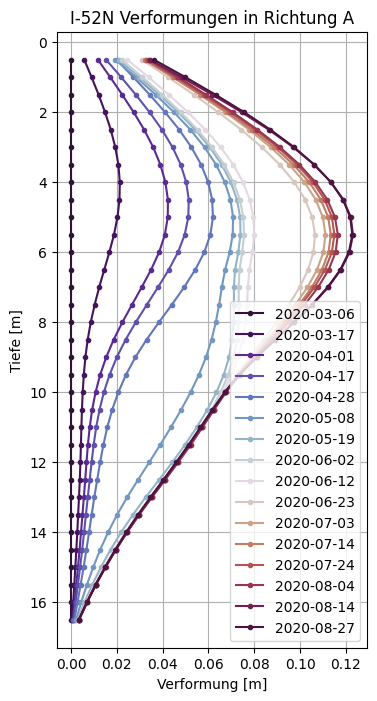

In [14]:
# Inclinometer I-52N, deformations in direction A


plt.figure(figsize=(4,8))
plt.title('I-52N Verformungen in Richtung A')

# We plot only every third measurement, because otherwise the graph is a little too crowded.

i=0
for my_date in dates_as_list[0::3]:
  c = cm.twilight_shifted(i/16.,1)
  df_1 = df.loc[(df.index == my_date) & (df['tube'] == 'I-52N'), :]
  legend_date = my_date.date()
  plt.plot(df_1['A_defo_relat'], df_1['depth'], color=c, marker='.', linestyle='-', label=legend_date)
  i+=1

plt.gca().invert_yaxis()
plt.grid(visible=True, which='major', axis='both')
plt.xlabel('Verformung [m]')
plt.ylabel('Tiefe [m]')
plt.legend()
plt.show()

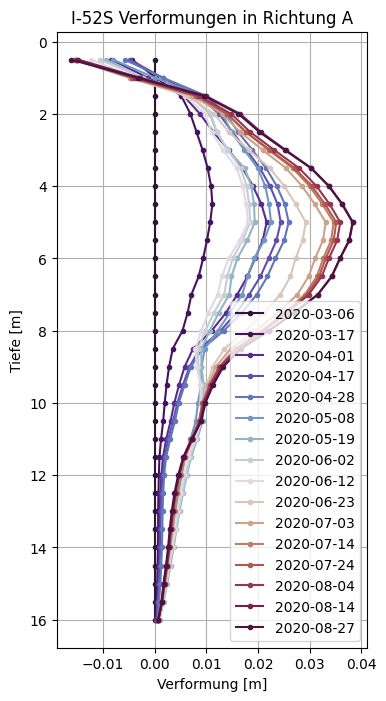

In [15]:
# Inclinometer I-52S, deformations in direction A


plt.figure(figsize=(4,8))
plt.title('I-52S Verformungen in Richtung A')

# We plot only every third measurement, because otherwise the graph is a little too crowded.

i=0
for my_date in dates_as_list[0::3]:
  c = cm.twilight_shifted(i/16.,1)
  df_1 = df.loc[(df.index == my_date) & (df['tube'] == 'I-52S'), :]
  legend_date = my_date.date()
  plt.plot(df_1['A_defo_relat'], df_1['depth'], color=c, marker='.', linestyle='-', label=legend_date)
  i+=1

plt.gca().invert_yaxis()
plt.grid(visible=True, which='major', axis='both')
plt.xlabel('Verformung [m]')
plt.ylabel('Tiefe [m]')
plt.legend()
plt.show()

# Vergleich zwischen Plaxis und Inklinometer

In [16]:
dates_Phase4 = ['2020-05-01', '2020-05-08', '2020-05-12', '2020-05-19', '2020-05-29', '2020-06-05']

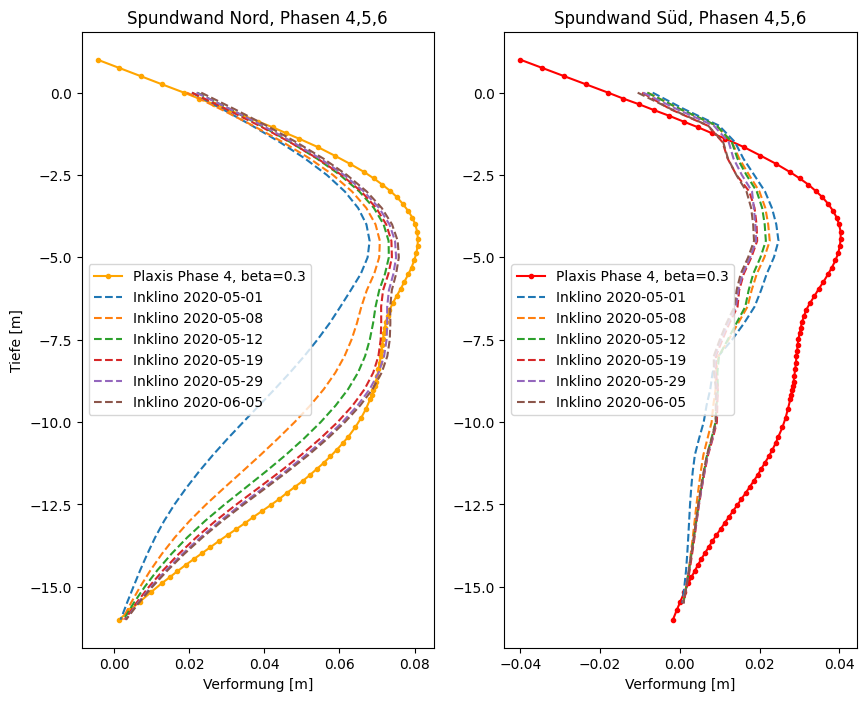

In [17]:
##    Phasen 4,5,6    ###

plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.title('Spundwand Nord, Phasen 4,5,6')
plt.plot(-df_plaxis_uN_03['Aushub_Phase4_[m]_03'], df_plaxis_uN_03['Y_coordinate_[m]_03'], color='orange', marker='.', linestyle='-', label='Plaxis Phase 4, beta=0.3')
for mydate in dates_Phase4:
  df_1 = df.loc[(df.index == mydate) & (df['tube'] == 'I-52N'), :]
  legend_1 = 'Inklino ' + str(mydate)
  plt.plot(df_1['A_defo_relat'], -df_1['depth']+0.5, linestyle='--', label=legend_1)
plt.legend()
plt.xlabel('Verformung [m]')
plt.ylabel('Tiefe [m]')

plt.subplot(1,2,2)
plt.title('Spundwand Süd, Phasen 4,5,6')
plt.plot(df_plaxis_uS_03['Aushub_Phase4_[m]_03'], df_plaxis_uS_03['Y_coordinate_[m]_03'], color='red', marker='.', linestyle='-', label='Plaxis Phase 4, beta=0.3')
for mydate in dates_Phase4:
  df_1 = df.loc[(df.index == mydate) & (df['tube'] == 'I-52S'), :]
  legend_1 = 'Inklino ' + str(mydate)
  plt.plot(df_1['A_defo_relat'], -df_1['depth']+0.5, linestyle='--', label=legend_1)
plt.legend()
plt.xlabel('Verformung [m]')

plt.show()

# Rückrechnung von $\beta_D$ basierend auf den Momenten aus Plaxis

## Vorbereitung der Inklinometerdaten

Dieser Abschnitt ist identisch zu '`Wylerfeld.ipynb`'.

In [18]:
# Fit a polynom of 9th degree to the displacements (inclinometer data).
# Save the coefficients in a dataframe.

Retaining_wall = ['North', 'South']
coefficients = ['a9', 'a8', 'a7', 'a6', 'a5', 'a4', 'a3', 'a2', 'a1', 'a0']
Phase = ['Phase 4-5-6']

my_index = pd.MultiIndex.from_product([Retaining_wall, Phase], names=['Retaining_wall', 'Phase'])
df_coeff_inclino = pd.DataFrame(np.zeros([2, 10]), index=my_index, columns = coefficients)

#df_coeff_inclino

In [19]:
# Sheet pile wall North
df_N456 = df.loc[(df.index == '2020-05-15') & (df['tube'] == 'I-52N'), :]
df_coeff_inclino.loc[('North', 'Phase 4-5-6'), :] = np.polyfit(df_N456['depth'], df_N456['A_defo_relat'], 9)

# Sheet pile wall South
df_S456 = df.loc[(df.index == '2020-05-15') & (df['tube'] == 'I-52S'), :]
df_coeff_inclino.loc[('South', 'Phase 4-5-6'), :] = np.polyfit(df_S456['depth'], df_S456['A_defo_relat'], 9)

df_coeff_inclino

,,a9,a8,a7,a6,a5,a4,a3,a2,a1,a0
Retaining_wall,Phase,,,,,,,,,,
North,Phase 4-5-6,1.236944e-09,-9.500272e-08,0.000003,-0.000051,0.000501,-0.002804,0.008539,-0.014532,0.029132,0.011112
South,Phase 4-5-6,4.829692e-10,-4.324949e-08,0.000002,-0.000033,0.000389,-0.002805,0.012140,-0.031750,0.052379,-0.029280


In [20]:
Y_coord = pd.Series(np.arange(0, -16.25, -0.25))  # y-coordinate [m] as in the Plaxis model
df_fit_inclino = pd.DataFrame(data = Y_coord, columns=['Y_coord'])
df_fit_inclino['depth'] = -Y_coord + 0.5                    # inclinometer depth


# w indicates displacement
# w1 indicates slope, the first derivative of w
# w2 indicates curvature, the second derivative of w


# calculate fitted values, North
df_fit_inclino['w_N456'] = np.polyval(df_coeff_inclino.loc[('North', 'Phase 4-5-6'), :], df_fit_inclino['depth'])

# calculate fitted values, South
df_fit_inclino['w_S456'] = np.polyval(df_coeff_inclino.loc[('South', 'Phase 4-5-6'), :], df_fit_inclino['depth'])

df_fit_inclino.head(5)

,Y_coord,depth,w_N456,w_S456
0,0.00,0.50,0.022952,-0.009674
1,-0.25,0.75,0.027613,-0.003535
2,-0.50,1.00,0.031901,0.001042
3,-0.75,1.25,0.036002,0.004517
4,-1.00,1.50,0.040011,0.007233


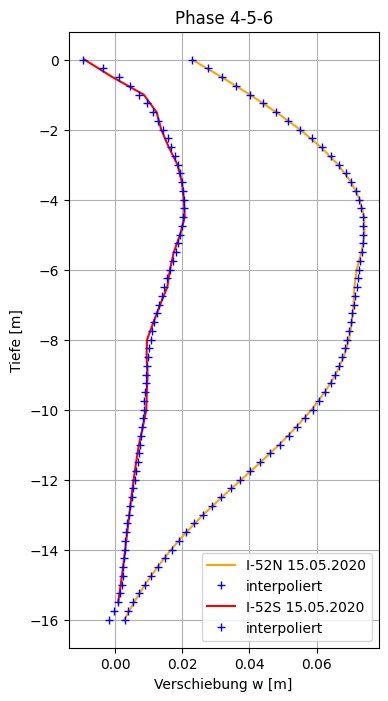

In [21]:
plt.figure(figsize=(4,8))

plt.title('Phase 4-5-6')
plt.plot(df_N456['A_defo_relat'], -df_N456['depth']+0.5, color='orange', linestyle='-', label='I-52N 15.05.2020')
plt.plot(df_fit_inclino['w_N456'], df_fit_inclino['Y_coord'], 'b+', label = 'interpoliert')
plt.plot(df_S456['A_defo_relat'], -df_S456['depth']+0.5, color='red', linestyle='-', label='I-52S 15.05.2020')
plt.plot(df_fit_inclino['w_S456'], df_fit_inclino['Y_coord'], 'b+', label = 'interpoliert')
plt.grid(visible=True, which='major', axis='both')
plt.xlabel('Verschiebung w [m]')
plt.ylabel('Tiefe [m]')
plt.legend()

plt.show()

In [22]:
# w indicates displacement
# w1 indicates slope, the first derivative of w
# w2 indicates curvature, the second derivative of w


# w1
for index, row in df_fit_inclino.iterrows():
  if index == 0 or index == 64:
    df_fit_inclino.at[index, 'w1_N456'] = np.nan
    df_fit_inclino.at[index, 'w1_S456'] = np.nan
  else:
    df_fit_inclino.at[index, 'w1_N456'] = (df_fit_inclino.at[(index+1), 'w_N456'] - df_fit_inclino.at[(index-1), 'w_N456']) / (df_fit_inclino.at[(index+1), 'Y_coord'] - df_fit_inclino.at[(index-1), 'Y_coord'])
    df_fit_inclino.at[index, 'w1_S456'] = (df_fit_inclino.at[(index+1), 'w_S456'] - df_fit_inclino.at[(index-1), 'w_S456']) / (df_fit_inclino.at[(index+1), 'Y_coord'] - df_fit_inclino.at[(index-1), 'Y_coord'])

# w2
for index, row in df_fit_inclino.iterrows():
  if index <= 1 or index >= 63:
    df_fit_inclino.at[index, 'w2_N456'] = np.nan
    df_fit_inclino.at[index, 'w2_S456'] = np.nan
  else:
    df_fit_inclino.at[index, 'w2_N456'] = (df_fit_inclino.at[(index+1), 'w1_N456'] - df_fit_inclino.at[(index-1), 'w1_N456']) / (df_fit_inclino.at[(index+1), 'Y_coord'] - df_fit_inclino.at[(index-1), 'Y_coord'])
    df_fit_inclino.at[index, 'w2_S456'] = (df_fit_inclino.at[(index+1), 'w1_S456'] - df_fit_inclino.at[(index-1), 'w1_S456']) / (df_fit_inclino.at[(index+1), 'Y_coord'] - df_fit_inclino.at[(index-1), 'Y_coord'])

#df_fit_inclino

## Vorbereiten der Momenten aus Plaxis

Der Momentenverlauf in den VL607 Profilen wurde mit Plaxis-2D berechnet. Um eine solche Simulation durchzuführen, muss der Anwender einen Wert der Steifigkeit eingeben, welcher den Abimnderungsfaktor $\beta_D$ berücksichtigt.

Der Momentenverlauf wird mit einem **Polynom 7. Grades** interpoliert.

In [23]:
# For the Northern sheet pile wall, we have to "mirror" the moment distribution to match the inclinometers measurements.

df_plaxis_MN_03['Aushub_Phase4_[kNm/m]_03'] = -1*df_plaxis_MN_03['Aushub_Phase4_[kNm/m]_03']

In [24]:
# Fit a polynom of 7th degree to the moments (obtained from Plaxis).
# Save the coefficients in a dataframe.

Retaining_wall = ['North', 'South']
Phase = ['Phase 4-5-6']
reduction_factor = ['beta_03']
coefficients = ['a7', 'a6', 'a5', 'a4', 'a3', 'a2', 'a1', 'a0']

my_index = pd.MultiIndex.from_product([Retaining_wall, Phase, reduction_factor], names=['Retaining_wall', 'Phase', 'Reduction_factor'])
df_coeff_moment_03 = pd.DataFrame(np.zeros([2, 8]), index=my_index, columns = coefficients)

#df_coeff_moment_03

In [25]:
# Sheet pile wall North
df_coeff_moment_03.loc[('North', 'Phase 4-5-6', 'beta_03'), :] = np.polyfit(df_plaxis_MN_03['Y_coordinate_[m]_03'], df_plaxis_MN_03['Aushub_Phase4_[kNm/m]_03'], 7)

# Sheet pile wall South
df_coeff_moment_03.loc[('South', 'Phase 4-5-6', 'beta_03'), :] = np.polyfit(df_plaxis_MS_03['Y_coordinate_[m]_03'], df_plaxis_MS_03['Aushub_Phase4_[kNm/m]_03'], 7)

df_coeff_moment_03

,,,a7,a6,a5,a4,a3,a2,a1,a0
Retaining_wall,Phase,Reduction_factor,,,,,,,,
North,Phase 4-5-6,beta_03,0.001057,0.064933,1.529033,17.056969,87.728722,144.991158,-137.283149,-28.274766
South,Phase 4-5-6,beta_03,0.001064,0.064218,1.494364,16.567934,85.138655,140.565323,-135.240394,-26.195210


In [26]:
# Let's construct a multi-index dataframe where we are going to save all of our calculation results.

Wall = ['North, beta_03', 'South, beta_03']   # these are the reduction factors used in the Plaxis simulations
Y_coord = Y_coord
back_calculation = ['moment_M', 'stiffness_EI', 'beta'] # we aim at back calculationg beta

my_index = pd.MultiIndex.from_product([Wall, back_calculation], names=['wall', 'back calculation'])

# BC means back calculation

df_BC = pd.DataFrame(np.zeros([6, 65]), index=my_index, columns = Y_coord)
df_BC = df_BC.T
#df_BC

In [27]:
# interpolation of the moment obtained with Plaxis-2D by a polynomial

df_BC.loc[:, ('North, beta_03', 'moment_M')] = np.polyval(df_coeff_moment_03.loc[('North', 'Phase 4-5-6', 'beta_03'), :], Y_coord)
df_BC.loc[:, ('South, beta_03', 'moment_M')] = np.polyval(df_coeff_moment_03.loc[('South', 'Phase 4-5-6', 'beta_03'), :], Y_coord)

#df_BC

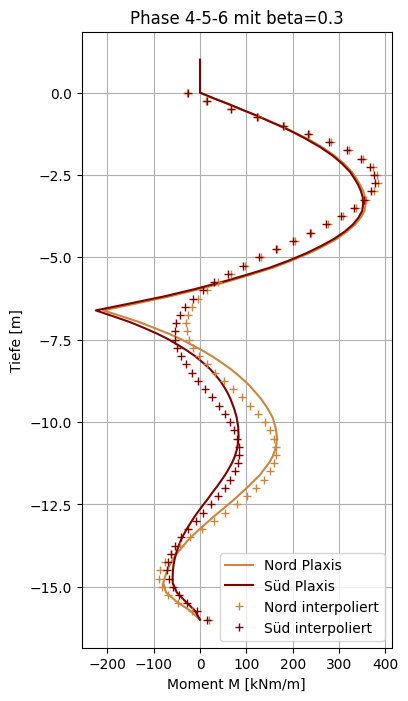

In [28]:
# Comparison of the moments obtined from Plaxis (continuous line) with the interpolated moments (cross)

plt.figure(figsize=(4,8))

plt.title('Phase 4-5-6 mit beta=0.3')
plt.plot(df_plaxis_MN_03['Aushub_Phase4_[kNm/m]_03'], df_plaxis_MN_03['Y_coordinate_[m]_03'], color='peru', linestyle='-', label='Nord Plaxis')
plt.plot(df_plaxis_MS_03['Aushub_Phase4_[kNm/m]_03'], df_plaxis_MS_03['Y_coordinate_[m]_03'], color='maroon', linestyle='-', label='Süd Plaxis')
plt.plot(df_BC[('North, beta_03', 'moment_M')], df_BC.index, color='peru', linestyle='', marker='+', label='Nord interpoliert')
plt.plot(df_BC[('South, beta_03', 'moment_M')], df_BC.index, color='maroon', linestyle='', marker='+', label='Süd interpoliert')
plt.grid(visible=True, which='major', axis='both')
plt.xlabel('Moment M [kNm/m]')
plt.ylabel('Tiefe [m]')
plt.legend()

plt.show()

In [29]:
# Let's back calculate the reduction factor beta.

# stiffness for a continuous sheet pile wall of VL607-profiles, according to Stabau GmbH, in [kNm2/m]
EI_continuous = 153930

# the two dataframes work with different indeces:
# df_BC: 0.00, -0.25, -0.50, ...
# df_fit_inclino: 0, 1, 2, ...
i = 0

for index, row in df_BC.iterrows():
  # EI = -M / w2
  df_BC.at[index, ('North, beta_03', 'stiffness_EI')] = -df_BC.at[index, ('North, beta_03', 'moment_M')] / df_fit_inclino.at[i, 'w2_N456']
  df_BC.at[index, ('South, beta_03', 'stiffness_EI')] = -df_BC.at[index, ('South, beta_03', 'moment_M')] / df_fit_inclino.at[i, 'w2_N456']

  # beta = EI / EI_continuous
  df_BC.at[index, ('North, beta_03', 'beta')] = df_BC.at[index, ('North, beta_03', 'stiffness_EI')] / EI_continuous
  df_BC.at[index, ('South, beta_03', 'beta')] = df_BC.at[index, ('South, beta_03', 'stiffness_EI')] / EI_continuous

  i += 1

#df_BC

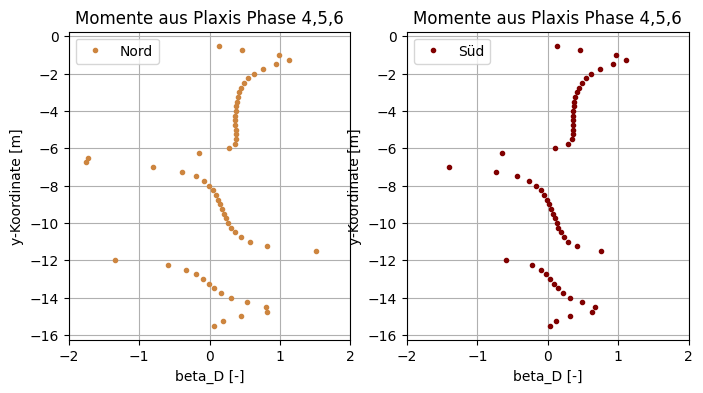

In [30]:
# Let's plot the reduction factor beta.

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.title('Momente aus Plaxis Phase 4,5,6')
plt.plot(df_BC[('North, beta_03', 'beta')], df_BC.index, color='peru', linestyle='', marker='.', label = 'Nord')
plt.xlim(-2, 2)
plt.grid(visible=True, which='major', axis='both')
plt.xlabel('beta_D [-]')
plt.ylabel('y-Koordinate [m]')
plt.legend()

plt.subplot(1,2,2)
plt.title('Momente aus Plaxis Phase 4,5,6')
plt.plot(df_BC[('South, beta_03', 'beta')], df_BC.index, color='maroon', linestyle='', marker='.', label = 'Süd')
plt.xlim(-2, 2)
plt.grid(visible=True, which='major', axis='both')
plt.xlabel('beta_D [-]')
plt.ylabel('y-Koordinate [m]')
plt.legend()

plt.show()

# Schlussfolgerungen

In [31]:
round(df_BC.loc[-3:-5 , ('North, beta_03', 'beta')].mean(), 3)

0.379

In [32]:
round(df_BC.loc[-3:-5 , ('South, beta_03', 'beta')].mean(), 3)

0.373

Die abgeschätzen Abminderungsfaktoren sind praktisch identisch:
$$\beta_D = 0.37 - 0.38$$

Im direkten Vergleich zwischen Inklinometermessungen und Wandverformungen aus Plaxis-2D ist ersichtlich, dass die Verformungen bei der Spundwand Nord recht gut übereinstimmen. Bei der Spundwand Süd sind die gemessenen Verfomungen hingegen deutlich tiefer als die simulierten. Trotzdem erhält man aus beiden Spundwänden den gleichen Abminderungsfaktor.

**WARUM?**

Die einzige Information aus dem Inklino, die in die Auswertung einfliesst, ist die Krümmung w''. Die maximalen Verformungen spielen keine Rolle.
Dann kommen noch die Momenten aus Plaxis ins Spiel, welche für beide Spundwänden (vor allem im Bereich Tiefe 3m - 5m) identisch sind.